In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.applications.vgg16 import preprocess_input 

# clustering and dimension reduction
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload
from src.dataLoader import dataLoader
from src.utils import image_utils, ismember

from src.preprocessing import imadjust,imagecrop,imagePaddingByShape


# Loading full dataset


In [2]:
dataset = dataLoader("../dataset")

fileNameList = [str(imgIdx)+".jpg" for imgIdx in range(1500,3000)]
imageFileList = dataset.LoadFileList(fileNameList=fileNameList)

In [3]:
class FeatureExtraction():
    def __init__(self, imageFileList:list):
        self.imageFileList = imageFileList
        model = VGG16()
        self.model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
        self.featureDict = {}
        self.fearutesData = np.array([])
        self.reducedFeature = np.array([])

    def extract_features(self, file, model):
        # load the image as a 224x224 array
        img = load_img(file, target_size=(224,224))
        # convert from 'PIL.Image.Image' to numpy array
        img = np.array(img) 
        # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
        reshaped_img = img.reshape(1,224,224,3) 
        # prepare image for model
        imgx = preprocess_input(reshaped_img)
        # get the feature vector
        features = model.predict(imgx, use_multiprocessing=True)
        return features
        
    def getFullFeature(self):
        for image_path in self.imageFileList:
            # try to extract the features and update the dictionary
            try:
                feat = self.extract_features(image_path,self.model)
                self.featureDict[image_path] = feat
            # if something fails, save the extracted features as a pickle file (optional)
            except:
                pass
        self.imageFileList = np.array(list(self.featureDict.keys()))
        # get a list of just the features
        self.fearutesData = np.array(list(self.featureDict.values())).reshape(-1,4096)
        print(self.fearutesData.shape)
        return self.fearutesData

    def getReducedFeature(self,n_components:int=100):
        pca = PCA(n_components=n_components)
        feat = self.getFullFeature()
        pca.fit(feat)
        self.reducedFeature = pca.transform(feat)
        print(f"Components before PCA: {feat.shape[1]}")
        print(f"Components after PCA: {pca.n_components}")

        plt.figure(figsize=(10,5))
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance');
        plt.show()
        return self.reducedFeature

In [ ]:
# ori_dataset = []

# for image_path in imageFileList:
#     # get RGB image
#     color_image = image_utils().get_image(image_path, image_scale=cv2.COLOR_BGR2RGB, is_gray=False)
#     ori_dataset.append(color_image)

# Initial Feature extraction on full dataset


(1500, 4096)
Components before PCA: 4096
Components after PCA: 100


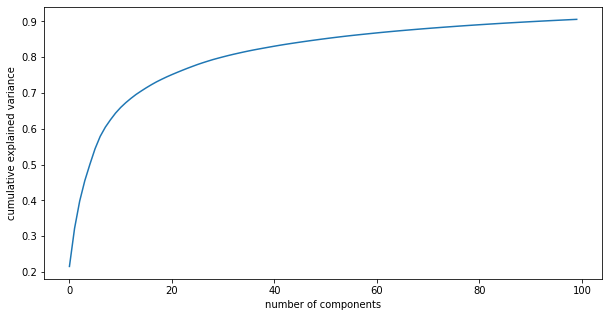

In [4]:
dataset_1st_ReducedFeatures = FeatureExtraction(imageFileList).getReducedFeature(n_components=100)

# Clustering


In [5]:
class Clustering():
    def __init__(
        self, 
        model, 
        Data:np.ndarray, 
        fileLocations:list, 
        NumCluster:int=5) -> None:
        self.model = model
        self.Data = Data
        self.fileLocations = fileLocations
        self.groups = {}
        self.NumCluster = NumCluster

    def train(self):
        # fit the model
        self.model.fit(self.Data)
        # assign a cluster to each example
        yhat = self.model.predict(self.Data)
        # holds the cluster id and the images { id: [images] }
        for file, cluster in zip(self.fileLocations,yhat):
            if cluster not in self.groups.keys():
                self.groups[cluster] = []
                self.groups[cluster].append(file)
            else:
                self.groups[cluster].append(file)
        return self

    def display_cluster(self,no_of_col:int = 10, cluster_idx=None):
        start_idx = 0
        end_idx = self.NumCluster
        if cluster_idx is not None:
            start_idx = cluster_idx
            end_idx = cluster_idx+1
        for i in range(start_idx,end_idx):
            filePaths_row = np.array(self.groups[i])
            num = filePaths_row.shape[0]
            r = np.floor(num/float(no_of_col))

            print("cluster "+str(i))
            print(str(num)+" elements")

            plt.figure(figsize=(10,10))
            plt.axis('off')
            for k in range(0, num):
                plt.subplot(r+1, no_of_col, k+1)
                image = load_img(filePaths_row[k])
                plt.imshow(image, cmap='gray')
                plt.title(filePaths_row[k].name, fontsize=8)
                plt.axis('off')
            plt.show()

In [6]:
NumCluster = 6

# KMeans clustering


In [7]:
# from sklearn.cluster import KMeans

# kmeans = Clustering(
#     KMeans(n_clusters=NumCluster,init='random'),
#     dataset_1st_ReducedFeatures,
#     imageFileList,
#     NumCluster=NumCluster
#     ).train()
# kmeans.display_cluster(no_of_col=10)

# Gaussian Mixture clustering


cluster 0
268 elements


D:\Anaconda3\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


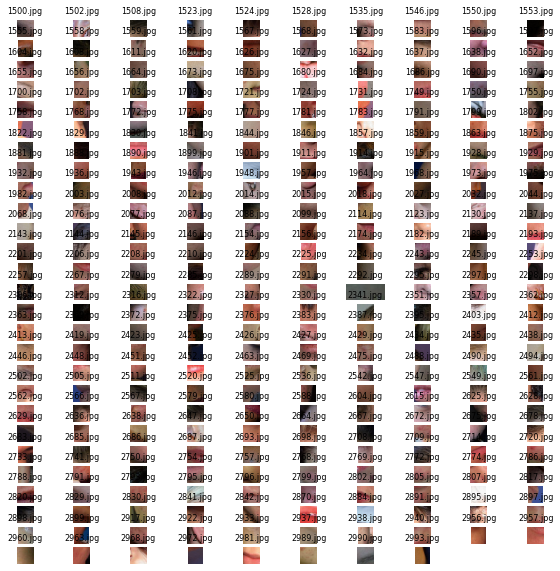

cluster 1
284 elements


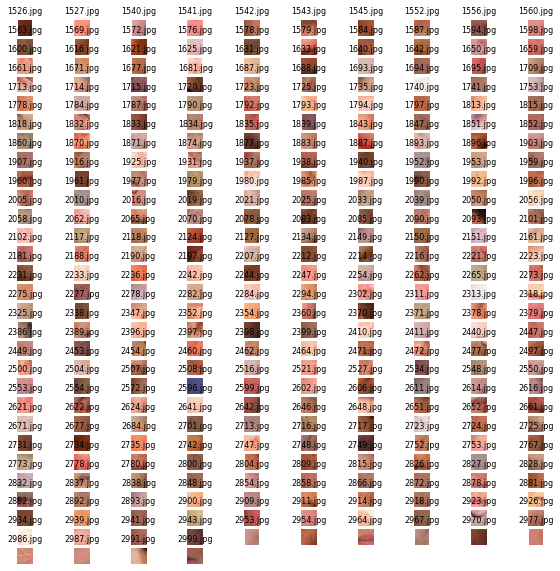

cluster 2
124 elements


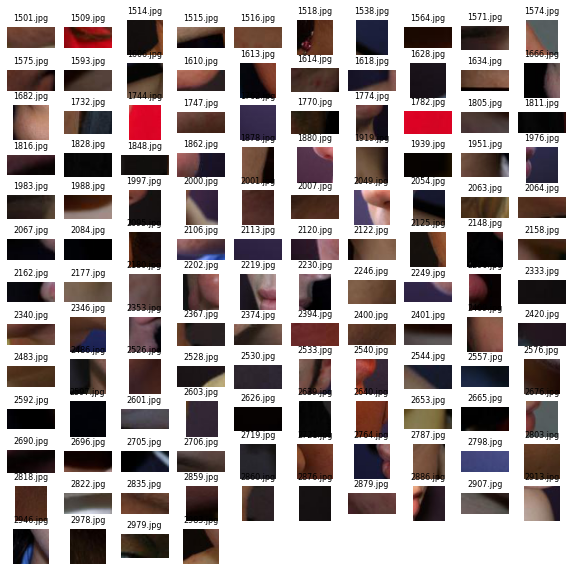

cluster 3
253 elements


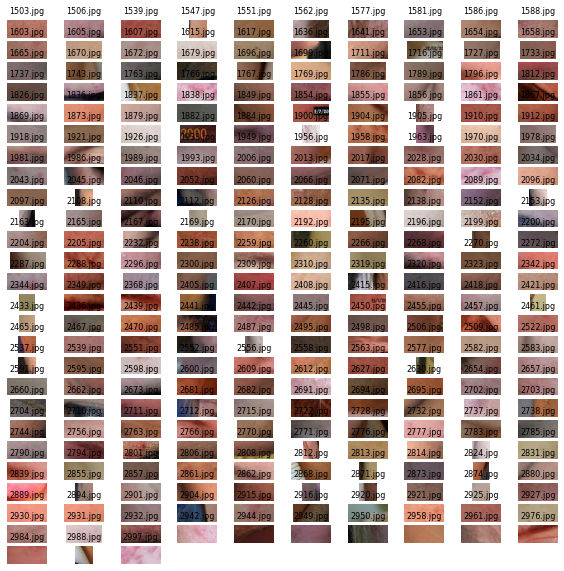

cluster 4
243 elements


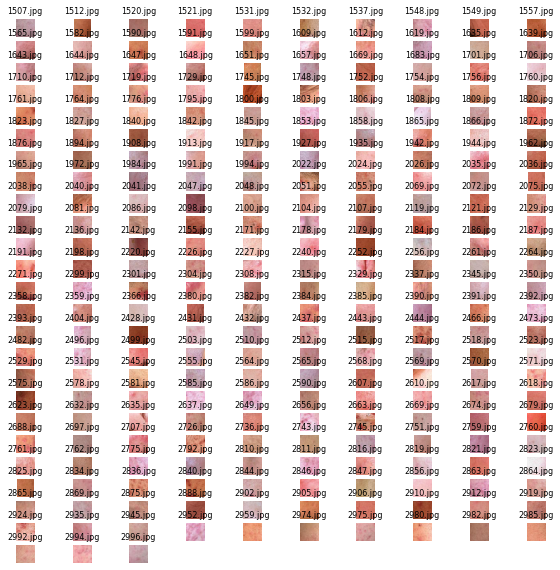

cluster 5
328 elements


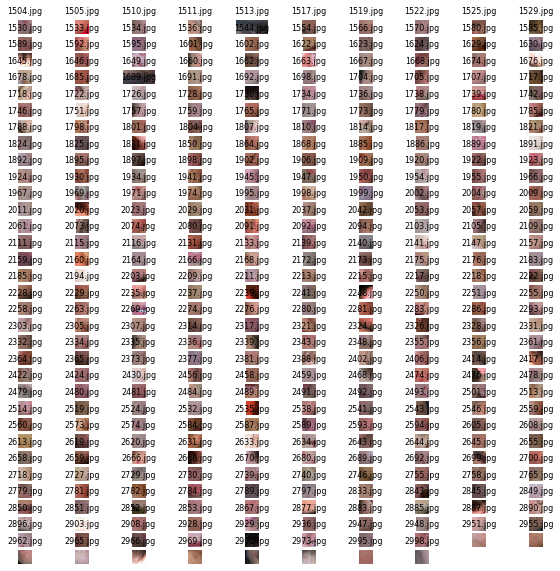

In [8]:
from sklearn.mixture import GaussianMixture

GMM1 = Clustering(
    GaussianMixture(n_components=NumCluster,random_state=1),
    dataset_1st_ReducedFeatures,
    imageFileList,
    NumCluster=NumCluster
    ).train()

GMM1.display_cluster()


In [ ]:
imageFileList_cluster = GMM1.groups[0]
Cluster_ReducedFeatures = FeatureExtraction(imageFileList_cluster).getReducedFeature(n_components=50)

NumCluster = 5
# GMM2 = Clustering(
#     GaussianMixture(n_components=NumCluster,random_state=1),
#     Cluster_ReducedFeatures,
#     imageFileList_cluster,
#     NumCluster=NumCluster
#     ).train()
from sklearn.cluster import KMeans

kmeans = Clustering(
    KMeans(n_clusters=NumCluster,init='random'),
    Cluster_ReducedFeatures,
    imageFileList_cluster,
    NumCluster=NumCluster
    ).train()

kmeans.display_cluster(no_of_col=10)

# Further extract from intra group


In [ ]:
import pandas as pd
# result_df = pd.DataFrame(imageFileList, columns=["file_path"])
# result_df["Image File"] = result_df["file_path"].astype(str).str.split("\\").str[-1]
# result_df['label'] = 0
# result_df['is_label'] = False
# result_df.head()

In [ ]:
def modify_label(df, image_idx, label):
    file_name = str(image_idx)+".jpg"
    df.loc[df["Image File"]==file_name, "label"] = label

In [ ]:
chosen_clusters = kmeans.groups[0]
label = 0
result_df.loc[(result_df.is_label==False) & (result_df.file_path.isin(chosen_clusters)), "label"] = label
result_df.loc[(result_df.is_label==False) & (result_df.file_path.isin(chosen_clusters)), "is_label"] = True
result_df.head()

In [ ]:
# result_df.to_csv(".\label.csv")


In [ ]:
image_idx = 709
label = 2
modify_label(result_df, image_idx, label)
result_df[result_df["Image File"]==f"{image_idx}.jpg"]

In [ ]:
kmeans.display_cluster(no_of_col=5,cluster_idx=4)

# ================================================================


In [ ]:
# # data cleaning
# GMM2_group = []
# for cluster in GMM1.groups:
#     imageFileList_cluster=cluster
#     print(len(imageFileList_cluster))
#     cluster_size = len(imageFileList_cluster)
#     Cluster_ReducedFeatures = FeatureExtraction(imageFileList_cluster).getReducedFeature(n_components=int(cluster_size/5))

#     NumCluster = 8
#     GMM2 = Clustering(
#         GaussianMixture(n_components=NumCluster,random_state=1),
#         Cluster_ReducedFeatures,
#         imageFileList_cluster,
#         NumCluster=NumCluster
#         ).train()

#     GMM2.display_cluster(no_of_col=5)

In [ ]:
# Cluster_ReducedFeatures = FeatureExtraction(imageFileList_cluster)\
#     .getReducedFeature(n_components=30)

In [ ]:
# NumCluster = 8
# GMM2 = Clustering(
#     GaussianMixture(n_components=NumCluster,random_state=1),
#     Cluster_ReducedFeatures,
#     imageFileList_cluster,
#     NumCluster=NumCluster
#     ).train()

# GMM2.display_cluster(no_of_col=5)

In [ ]:
# imageFileList_cluster=GMM2.groups[4]
# print(len(imageFileList_cluster))

# Cluster_ReducedFeatures = FeatureExtraction(imageFileList_cluster)\
#     .getReducedFeature(n_components=10)

# NumCluster = 3
# GMM3 = Clustering(
#     GaussianMixture(n_components=NumCluster,random_state=1),
#     Cluster_ReducedFeatures,
#     imageFileList_cluster,
#     NumCluster=NumCluster
#     ).train()

# GMM3.display_cluster(no_of_col=5)